**Volatility Regression**

In [4]:
# --- Cell 1: SETUP (RUN THIS FIRST) ---
# PINS chosen to avoid conflicts with Colab defaults and each other.
# Works on Python 3.12 in Colab at time of writing.

# mount (safe if already mounted)
from google.colab import drive
drive.mount("/content/drive", force_remount=True)




Mounted at /content/drive


In [8]:
# ===============================
# Study 2: Volatility Regression
# ===============================
# =========================================
# 30-day & 60-day RETURN REGRESSION + VOLATILITY REGRESSION
# =========================================
# If needed in Colab:
# from google.colab import drive
# drive.mount('/content/drive')

# -------- Config --------
CSV_PATH = "/content/drive/MyDrive/SAStockData/SAStockMarket1998-2024.csv"
USER_TICKER = "SOL.JO"            # e.g., "SOL.JO", "NPN.JO", "BHP.JO"
TRAIN_FRAC = 0.8
RSEED = 42

In [9]:
# -------- Imports --------
import math, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error
)
from sklearn.model_selection import TimeSeriesSplit

# Regressors
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# Permutation importance
from sklearn.inspection import permutation_importance

# Optional XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

np.random.seed(RSEED)

In [10]:
# -------- Helpers --------
def load_data(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    for c in list(df.columns):
        if c.lower().startswith("unnamed"):
            df = df.drop(columns=[c])
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)
    return df

def mape(y_true, y_pred, eps=1e-9):
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom))

def print_metrics(y_test, y_pred, label=""):
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    mp   = mape(y_test, y_pred)
    print(f"\n[{label}] RMSE={rmse:.6f} | MAE={mae:.6f} | R2={r2:.4f} | MAPE={mp:.4f}")
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE": mp}

def add_tech_indicators(d: pd.DataFrame, price_col="Adj Close") -> pd.DataFrame:
    d = d.copy()
    if price_col not in d.columns:
        price_col = "Close"

    # Returns
    d["ret_1d"] = d[price_col].pct_change()
    d["ret_5d"] = d[price_col].pct_change(5)

    # MAs / EMAs
    d["sma_5"]  = d[price_col].rolling(5).mean()
    d["sma_10"] = d[price_col].rolling(10).mean()
    d["ema_12"] = d[price_col].ewm(span=12, adjust=False).mean()
    d["ema_26"] = d[price_col].ewm(span=26, adjust=False).mean()

    # MACD
    d["macd"] = d["ema_12"] - d["ema_26"]
    d["macd_signal"] = d["macd"].ewm(span=9, adjust=False).mean()

    # RSI(14) — Wilder smoothing
    delta = d[price_col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/14, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/14, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    d["rsi_14"] = 100 - 100/(1 + rs)

    # Bollinger bandwidth (20)
    sma20 = d[price_col].rolling(20).mean()
    std20 = d[price_col].rolling(20).std()
    upper = sma20 + 2*std20
    lower = sma20 - 2*std20
    d["bb_width"] = (upper - lower) / sma20

    # ATR(14)
    prev_close = d["Close"].shift(1)
    tr1 = d["High"] - d["Low"]
    tr2 = (d["High"] - prev_close).abs()
    tr3 = (d["Low"] - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    d["atr_14"] = tr.rolling(14).mean()

    # Longer-context realized vol (optional predictors)
    d["ret_std_20"] = d[price_col].pct_change().rolling(20).std()
    d["ret_std_60"] = d[price_col].pct_change().rolling(60).std()

    return d

def lag_features(d: pd.DataFrame, cols: list, lags=(1,3,5,10)) -> pd.DataFrame:
    d = d.copy()
    for c in cols:
        for L in lags:
            d[f"{c}_lag{L}"] = d[c].shift(L)
    return d

def residual_diagnostics(y_test, y_pred, title_prefix=""):
    resid = y_test - y_pred

    # 1) True vs Pred (scatter)
    plt.figure(figsize=(5,4))
    plt.scatter(y_test, y_pred, s=8)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims)
    plt.title(f"{title_prefix} True vs Pred")
    plt.xlabel("True"); plt.ylabel("Pred")
    plt.tight_layout(); plt.show()

    # 2) True vs Pred (time)
    plt.figure(figsize=(8,3))
    plt.plot(y_test, label="True")
    plt.plot(y_pred, label="Pred")
    plt.legend(); plt.title(f"{title_prefix} True & Pred over Time")
    plt.tight_layout(); plt.show()

    # 3) Residuals over time
    plt.figure(figsize=(8,3))
    plt.plot(resid)
    plt.axhline(0)
    plt.title(f"{title_prefix} Residuals over Time")
    plt.tight_layout(); plt.show()

    # 4) Residual distribution
    plt.figure(figsize=(5,3))
    plt.hist(resid, bins=30)
    plt.title(f"{title_prefix} Residual Distribution")
    plt.tight_layout(); plt.show()

def built_in_importance(estimator, feature_names, top_n=15, title="Built-in Importances"):
    # Works for tree-based models (RandomForest/ExtraTrees/GBM/XGB)
    try:
        importances = None
        last = estimator[-1] if isinstance(estimator, Pipeline) else estimator
        if hasattr(last, "feature_importances_"):
            importances = last.feature_importances_
        if importances is None:
            return
        idx = np.argsort(importances)[::-1][:min(top_n, len(importances))]
        plt.figure(figsize=(8,4))
        plt.bar(range(len(idx)), importances[idx])
        plt.xticks(range(len(idx)), np.array(feature_names)[idx], rotation=90)
        plt.title(title)
        plt.tight_layout(); plt.show()
    except Exception:
        pass

def permutation_importance_plot(model, X_test, y_test, feature_names, top_n=15, scoring="neg_mean_squared_error", title="Permutation Importance"):
    try:
        r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=RSEED, scoring=scoring)
        means = r.importances_mean
        idx = np.argsort(np.abs(means))[::-1][:min(top_n, len(means))]
        plt.figure(figsize=(8,4))
        plt.bar(range(len(idx)), means[idx])
        plt.xticks(range(len(idx)), np.array(feature_names)[idx], rotation=90)
        plt.title(title)
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Permutation importance skipped:", e)

def walkforward_cv_rmse(model, X, y, splits=5):
    tscv = TimeSeriesSplit(n_splits=splits)
    rmses = []
    for tr_idx, te_idx in tscv.split(X):
        model.fit(X[tr_idx], y[tr_idx])
        pred = model.predict(X[te_idx])
        rmses.append(math.sqrt(mean_squared_error(y[te_idx], pred)))
    return np.array(rmses)

# -------- Load & choose ticker --------
df = load_data(CSV_PATH)

if USER_TICKER is None:
    preferred = ["SOL.JO","NPN.JO","BHP.JO","CFR.JO","ABG.JO"]
    counts = df["Ticker"].value_counts()
    TICKER = next((t for t in preferred if t in counts.index), counts.index[0])
else:
    TICKER = USER_TICKER

print("Using TICKER:", TICKER)
dft = df[df["Ticker"] == TICKER].copy()
price_col = "Adj Close" if "Adj Close" in dft.columns else "Close"



Using TICKER: SOL.JO


In [11]:
# -------- Feature engineering --------
dft = add_tech_indicators(dft, price_col=price_col)

base_cols = [
    "ret_1d","ret_5d","sma_5","sma_10","ema_12","ema_26",
    "macd","macd_signal","rsi_14","bb_width","atr_14",
    "ret_std_20","ret_std_60","Volume"
]
dft = lag_features(dft, base_cols, lags=(1,3,5,10))
dft = dft.dropna().reset_index(drop=True)

**Exploratory Data Analysis**

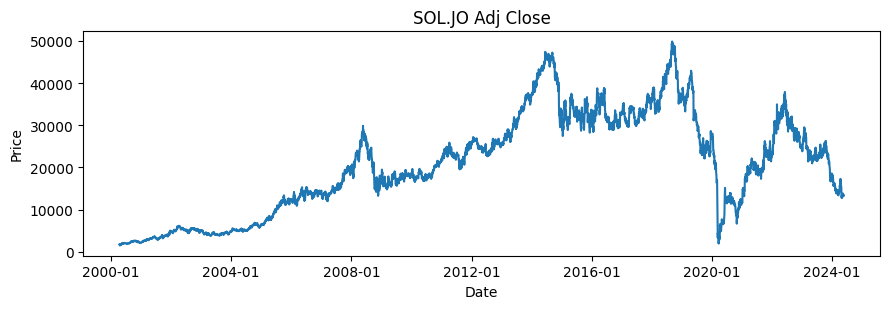

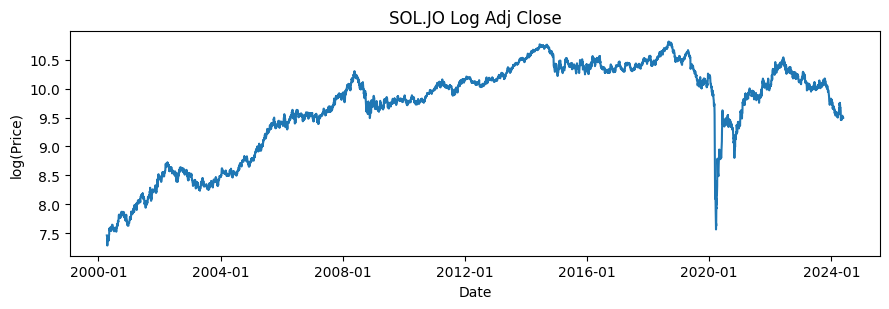

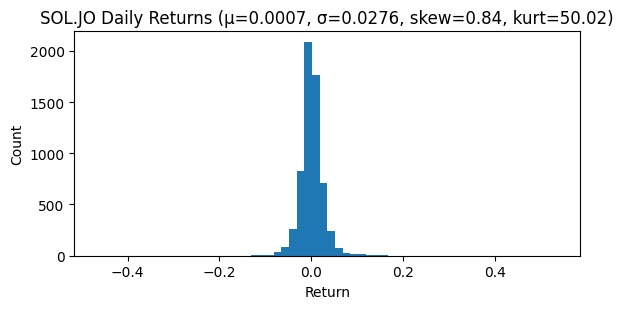

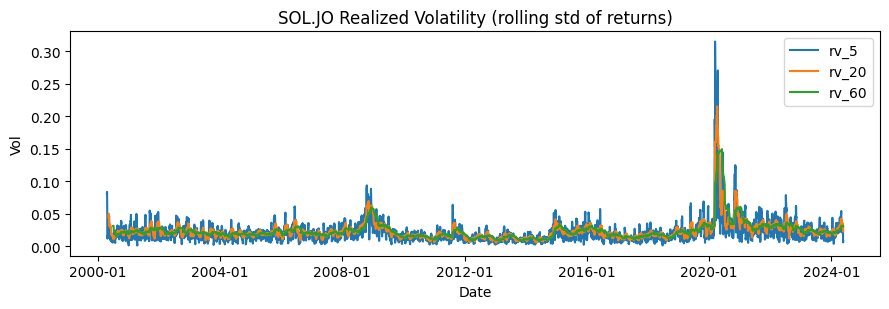

<Figure size 600x320 with 0 Axes>

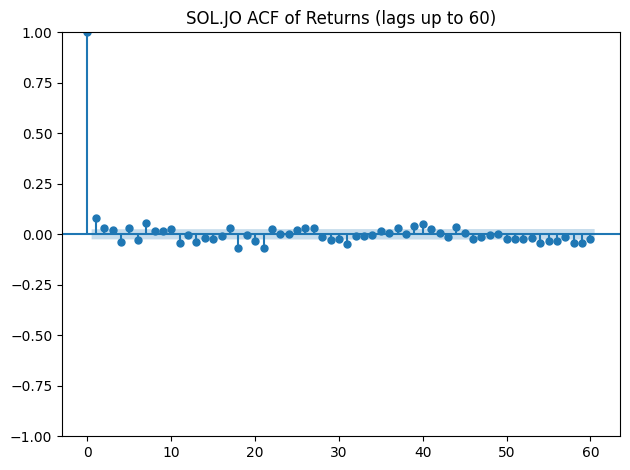

<Figure size 600x320 with 0 Axes>

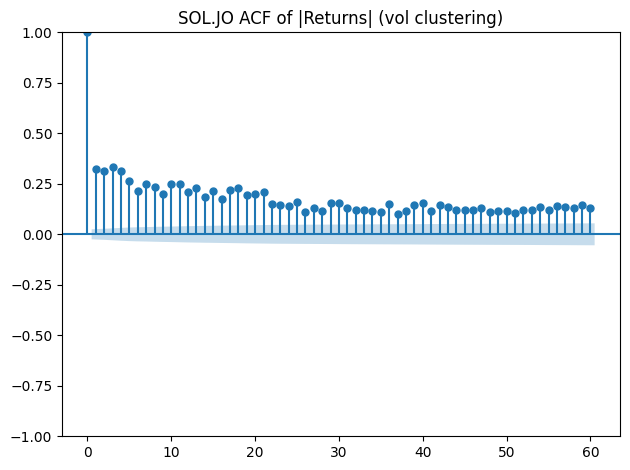

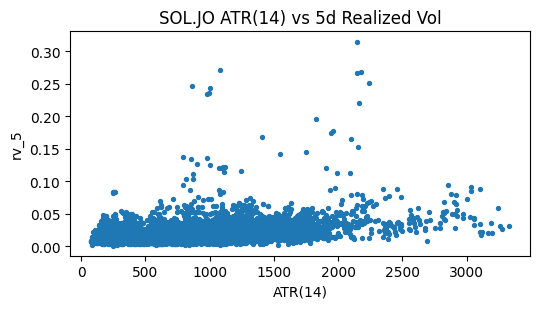

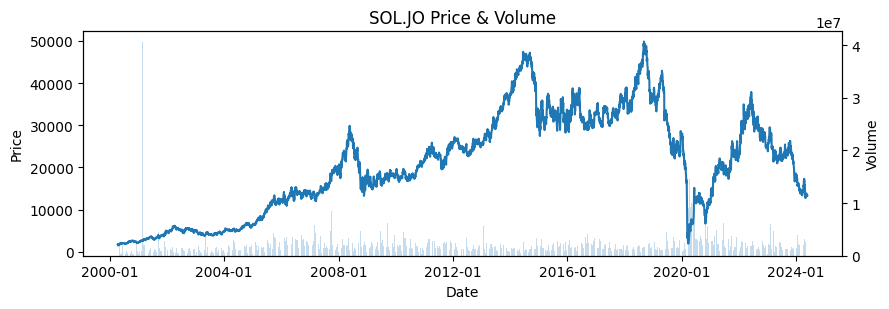

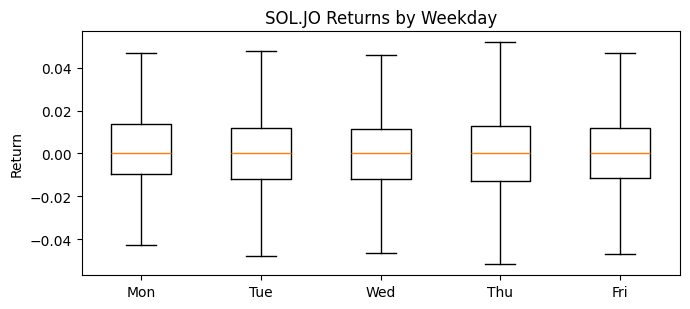

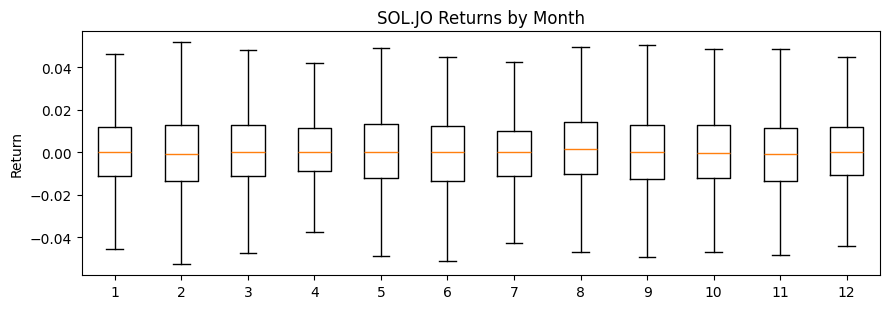

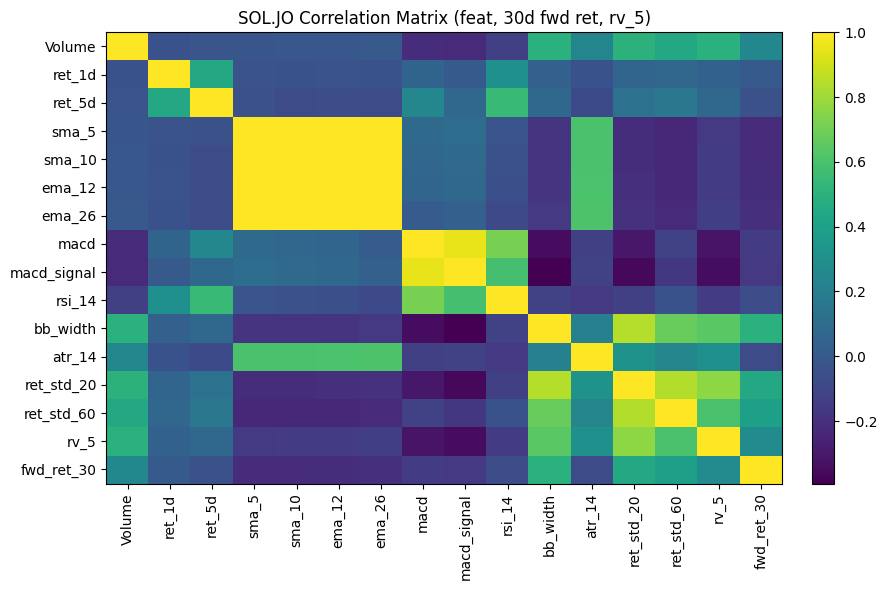

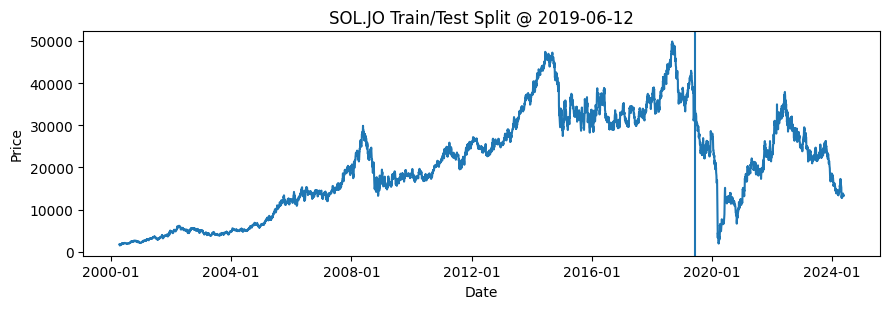

In [16]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def initial_eda(dft, price_col="Adj Close", train_frac=0.8, ticker=""):
    d = dft.copy()
    if "Date" in d.columns:
        d = d.sort_values("Date").set_index("Date")
    if price_col not in d.columns:
        price_col = "Close"

    # Core series
    d["ret_1d"] = d[price_col].pct_change()
    d["log_price"] = np.log(d[price_col])
    d["rv_5"]  = d[price_col].pct_change().rolling(5).std()
    d["rv_20"] = d[price_col].pct_change().rolling(20).std()
    d["rv_60"] = d[price_col].pct_change().rolling(60).std()
    if "atr_14" not in d.columns:
        # quick ATR if missing
        prev_close = d["Close"].shift(1) if "Close" in d.columns else d[price_col].shift(1)
        tr = pd.concat([(d["High"]-d["Low"]),
                        (d["High"]-prev_close).abs(),
                        (d["Low"]-prev_close).abs()], axis=1).max(axis=1)
        d["atr_14"] = tr.rolling(14).mean()

    # 1) Price
    plt.figure(figsize=(9,3.2))
    plt.plot(d.index, d[price_col])
    plt.title(f"{ticker} {price_col}"); plt.xlabel("Date"); plt.ylabel("Price")
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.tight_layout(); plt.show()

    # 2) Log-price
    plt.figure(figsize=(9,3.2))
    plt.plot(d.index, d["log_price"])
    plt.title(f"{ticker} Log {price_col}"); plt.xlabel("Date"); plt.ylabel("log(Price)")
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.tight_layout(); plt.show()

    # 3) Daily returns histogram
    r = d["ret_1d"].dropna()
    plt.figure(figsize=(6,3.2))
    plt.hist(r, bins=60)
    plt.title(f"{ticker} Daily Returns (μ={r.mean():.4f}, σ={r.std():.4f}, skew={r.skew():.2f}, kurt={r.kurt():.2f})")
    plt.xlabel("Return"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

    # 4) Rolling volatility (5/20/60d)
    plt.figure(figsize=(9,3.2))
    plt.plot(d.index, d["rv_5"], label="rv_5")
    plt.plot(d.index, d["rv_20"], label="rv_20")
    plt.plot(d.index, d["rv_60"], label="rv_60")
    plt.legend(); plt.title(f"{ticker} Realized Volatility (rolling std of returns)")
    plt.xlabel("Date"); plt.ylabel("Vol")
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.tight_layout(); plt.show()

    # 5) ACF of returns and |returns| (if statsmodels available)
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        plt.figure(figsize=(6,3.2))
        plot_acf(r, lags=60)
        plt.title(f"{ticker} ACF of Returns (lags up to 60)"); plt.tight_layout(); plt.show()

        plt.figure(figsize=(6,3.2))
        plot_acf(r.abs(), lags=60)
        plt.title(f"{ticker} ACF of |Returns| (vol clustering)"); plt.tight_layout(); plt.show()
    except Exception as e:
        print("Skipping ACF plots (statsmodels not available):", e)

    # 6) ATR vs realized vol (5d)
    df_sc = d[["atr_14","rv_5"]].dropna()
    if not df_sc.empty:
        plt.figure(figsize=(5.5,3.2))
        plt.scatter(df_sc["atr_14"], df_sc["rv_5"], s=8)
        plt.title(f"{ticker} ATR(14) vs 5d Realized Vol")
        plt.xlabel("ATR(14)"); plt.ylabel("rv_5")
        plt.tight_layout(); plt.show()

    # 7) Price with Volume (separate axis)
    if "Volume" in d.columns:
        fig, ax1 = plt.subplots(figsize=(9,3.2))
        ax1.plot(d.index, d[price_col])
        ax1.set_title(f"{ticker} Price & Volume")
        ax1.set_xlabel("Date"); ax1.set_ylabel("Price")
        ax2 = ax1.twinx()
        ax2.bar(d.index, d["Volume"].fillna(0), width=1.0, alpha=0.25)
        ax2.set_ylabel("Volume")
        ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        fig.tight_layout(); plt.show()

    # 8) Weekday and Month seasonality (boxplots)
    dd = d.copy()
    dd["weekday"] = dd.index.dayofweek
    dd["month"]   = dd.index.month
    if dd["ret_1d"].notna().sum() > 0:
        # weekday
        data_w = [dd.loc[dd["weekday"]==i, "ret_1d"].dropna().values for i in range(5)]
        plt.figure(figsize=(7,3.2))
        plt.boxplot(data_w, labels=["Mon","Tue","Wed","Thu","Fri"], showfliers=False)
        plt.title(f"{ticker} Returns by Weekday"); plt.ylabel("Return")
        plt.tight_layout(); plt.show()
        # month
        data_m = [dd.loc[dd["month"]==m, "ret_1d"].dropna().values for m in range(1,13)]
        plt.figure(figsize=(9,3.2))
        plt.boxplot(data_m, labels=list(range(1,13)), showfliers=False)
        plt.title(f"{ticker} Returns by Month"); plt.ylabel("Return")
        plt.tight_layout(); plt.show()

    # 9) Quick feature↔target correlations (30d fwd return + next-day vol)
    d["fwd_ret_30"] = d[price_col].shift(-30)/d[price_col] - 1.0
    corr_cols = [c for c in d.columns if c in [
        "ret_1d","ret_5d","sma_5","sma_10","ema_12","ema_26",
        "macd","macd_signal","rsi_14","bb_width","atr_14",
        "ret_std_20","ret_std_60","Volume","rv_5"
    ]]
    M = d[corr_cols + ["fwd_ret_30"]].dropna()
    if not M.empty:
        C = M.corr().values
        labels = list(M.columns)
        plt.figure(figsize=(9,6))
        im = plt.imshow(C, aspect="auto")
        plt.xticks(range(len(labels)), labels, rotation=90)
        plt.yticks(range(len(labels)), labels)
        plt.title(f"{ticker} Correlation Matrix (feat, 30d fwd ret, rv_5)")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.tight_layout(); plt.show()

    # 10) Train/Test split marker on price
    split_idx = int(len(d) * train_frac)
    if len(d) > 0 and 0 < split_idx < len(d):
        split_time = d.index[split_idx]
        plt.figure(figsize=(9,3.2))
        plt.plot(d.index, d[price_col])
        plt.axvline(split_time)
        plt.title(f"{ticker} Train/Test Split @ {split_time.date()}")
        plt.xlabel("Date"); plt.ylabel("Price")
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        plt.tight_layout(); plt.show()

# Example call (uses your existing dft/price_col/USER_TICKER/TRAIN_FRAC):
initial_eda(dft, price_col=price_col, train_frac=TRAIN_FRAC, ticker=TICKER)



==================== 30-DAY RETURN REGRESSION ====================

[30d LinearRegression] RMSE=0.260525 | MAE=0.164101 | R2=0.2801 | MAPE=42229.0643

[30d Ridge] RMSE=0.261158 | MAE=0.164083 | R2=0.2766 | MAPE=52320.0082

[30d Lasso] RMSE=0.307049 | MAE=0.175078 | R2=-0.0000 | MAPE=18645.4141

[30d RandomForestReg] RMSE=0.296430 | MAE=0.177354 | R2=0.0679 | MAPE=1216.9348

[30d GradientBoostingReg] RMSE=0.290556 | MAE=0.176573 | R2=0.1045 | MAPE=17067.4590

[30d ExtraTreesReg] RMSE=0.300984 | MAE=0.178379 | R2=0.0391 | MAPE=10810.8764

[30d KNNReg] RMSE=0.314222 | MAE=0.183033 | R2=-0.0473 | MAPE=54756.7522

[30d XGBReg] RMSE=0.299168 | MAE=0.181943 | R2=0.0506 | MAPE=23580.2093

=== Results (sorted by RMSE, then MAE) — 30 days ===


,Model,RMSE,MAE,R2,MAPE
0,LinearRegression,0.260525,0.164101,0.280056,42229.064262
1,Ridge,0.261158,0.164083,0.276554,52320.008153
2,GradientBoostingReg,0.290556,0.176573,0.104511,17067.458972
3,RandomForestReg,0.296430,0.177354,0.067939,1216.934793
4,XGBReg,0.299168,0.181943,0.050644,23580.209310
5,ExtraTreesReg,0.300984,0.178379,0.039083,10810.876378
6,Lasso,0.307049,0.175078,-0.000034,18645.414125
7,KNNReg,0.314222,0.183033,-0.047302,54756.752206



Best model @ 30d (by RMSE): LinearRegression


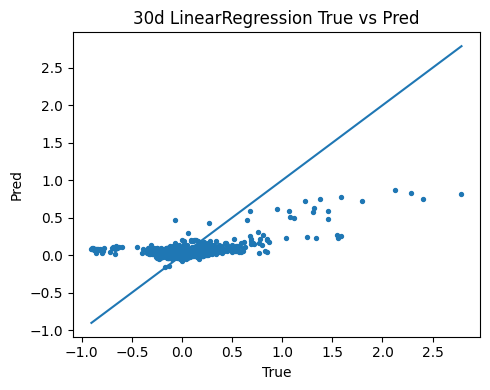

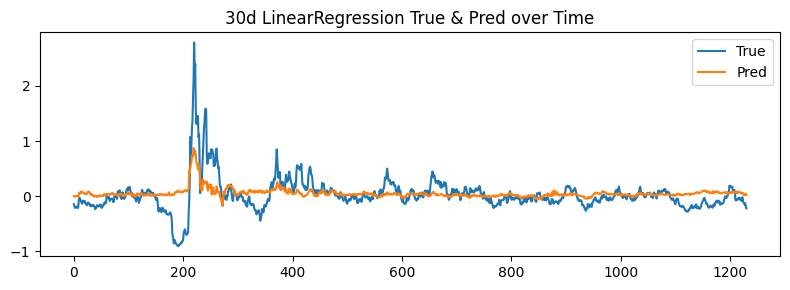

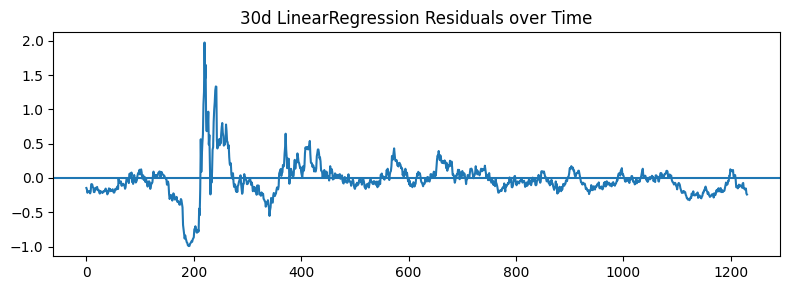

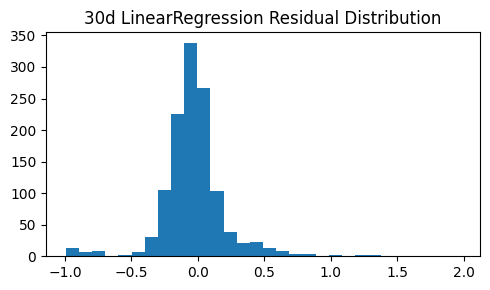

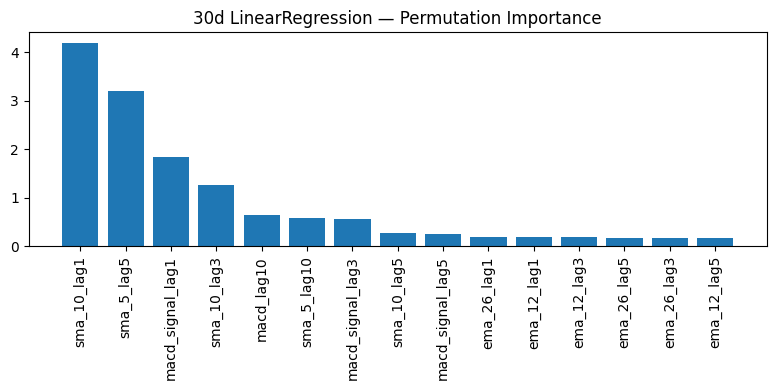


Walk-forward CV (RMSE) for best model:
Splits RMSE: [0.344738 0.105955 0.090238 0.177697 0.365864]
Mean RMSE: 0.216898  | Std: 0.11698


In [17]:
# -------- Return Regression (Generic) --------
def study_return_regression_horizon(dframe, price_col, horizon_days=30, train_frac=0.8):
    """
    Predict forward N-day return: y = price[t+N]/price[t] - 1
    Models: Linear, Ridge, Lasso, RF, GBM, ExtraTrees, KNN (+ XGB if available)
    Thorough evaluation + diagnostics + feature importances.
    """
    d = dframe.copy()
    y = d[price_col].shift(-horizon_days)/d[price_col] - 1.0

    feature_cols = [c for c in d.columns if c.endswith("_lag1") or c.endswith("_lag3") or c.endswith("_lag5") or c.endswith("_lag10")]
    data = d.dropna(subset=feature_cols + [price_col]).copy()
    # align y
    data["y_target"] = y.loc[data.index]
    data = data.dropna(subset=["y_target"]).reset_index(drop=True)

    X = data[feature_cols].values
    y_vec = data["y_target"].values

    split = int(len(data) * train_frac)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y_vec[:split], y_vec[split:]

    models = {
        "LinearRegression": Pipeline([("scaler", StandardScaler()), ("reg", LinearRegression())]),
        "Ridge": Pipeline([("scaler", StandardScaler()), ("reg", Ridge())]),
        "Lasso": Pipeline([("scaler", StandardScaler()), ("reg", Lasso())]),
        "RandomForestReg": RandomForestRegressor(n_estimators=600, random_state=RSEED),
        "GradientBoostingReg": GradientBoostingRegressor(random_state=RSEED),
        "ExtraTreesReg": ExtraTreesRegressor(n_estimators=600, random_state=RSEED),
        "KNNReg": Pipeline([("scaler", StandardScaler()), ("reg", KNeighborsRegressor(n_neighbors=15))]),
    }
    if HAS_XGB:
        models["XGBReg"] = XGBRegressor(
            n_estimators=700, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=RSEED
        )

    # Fit & evaluate
    rows = []
    fitted = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        metrics = print_metrics(y_test, pred, label=f"{horizon_days}d {name}")
        row = {"Model": name, **metrics}
        rows.append(row)
        fitted[name] = model

    results_df = pd.DataFrame(rows).sort_values(by=["RMSE","MAE"]).reset_index(drop=True)
    print("\n=== Results (sorted by RMSE, then MAE) —", horizon_days, "days ===")
    display(results_df)

    # Best model by RMSE
    best_name = results_df.iloc[0]["Model"]
    best_model = fitted[best_name]
    print(f"\nBest model @ {horizon_days}d (by RMSE): {best_name}")

    # Diagnostics for best model
    y_pred_best = best_model.predict(X_test)
    residual_diagnostics(y_test, y_pred_best, title_prefix=f"{horizon_days}d {best_name}")

    # Built-in importances (if any)
    feature_names = np.array(feature_cols)
    built_in_importance(best_model, feature_names, title=f"{horizon_days}d {best_name} — Built-in Feature Importance")

    # Permutation importance (model-agnostic)
    permutation_importance_plot(best_model, X_test, y_test, feature_names,
                                scoring="neg_mean_squared_error",
                                title=f"{horizon_days}d {best_name} — Permutation Importance")

    # Walk-forward CV (best model)
    print("\nWalk-forward CV (RMSE) for best model:")
    rmses = walkforward_cv_rmse(best_model, X, y_vec, splits=5)
    print("Splits RMSE:", np.round(rmses, 6))
    print("Mean RMSE:", np.round(rmses.mean(), 6), " | Std:", np.round(rmses.std(), 6))

    return results_df, best_name, best_model

# -------- Run: 30-day & 60-day return regression --------
print("\n==================== 30-DAY RETURN REGRESSION ====================")
res30, name30, model30 = study_return_regression_horizon(dft, price_col, horizon_days=30, train_frac=TRAIN_FRAC)




==================== 60-DAY RETURN REGRESSION ====================

[60d LinearRegression] RMSE=0.441081 | MAE=0.258656 | R2=0.3148 | MAPE=3.6132

[60d Ridge] RMSE=0.440707 | MAE=0.258785 | R2=0.3160 | MAPE=3.6191

[60d Lasso] RMSE=0.532869 | MAE=0.286850 | R2=-0.0001 | MAPE=3.6329

[60d RandomForestReg] RMSE=0.526504 | MAE=0.279441 | R2=0.0237 | MAPE=3.4328

[60d GradientBoostingReg] RMSE=0.521526 | MAE=0.279150 | R2=0.0421 | MAPE=4.6064

[60d ExtraTreesReg] RMSE=0.516584 | MAE=0.276061 | R2=0.0601 | MAPE=4.3843

[60d KNNReg] RMSE=0.535856 | MAE=0.284362 | R2=-0.0113 | MAPE=3.3793

[60d XGBReg] RMSE=0.522561 | MAE=0.282005 | R2=0.0383 | MAPE=3.9227

=== Results (sorted by RMSE, then MAE) — 60 days ===


,Model,RMSE,MAE,R2,MAPE
0,Ridge,0.440707,0.258785,0.315952,3.619090
1,LinearRegression,0.441081,0.258656,0.314791,3.613163
2,ExtraTreesReg,0.516584,0.276061,0.060129,4.384251
3,GradientBoostingReg,0.521526,0.279150,0.042060,4.606447
4,XGBReg,0.522561,0.282005,0.038257,3.922678
5,RandomForestReg,0.526504,0.279441,0.023686,3.432830
6,Lasso,0.532869,0.286850,-0.000060,3.632885
7,KNNReg,0.535856,0.284362,-0.011304,3.379252



Best model @ 60d (by RMSE): Ridge


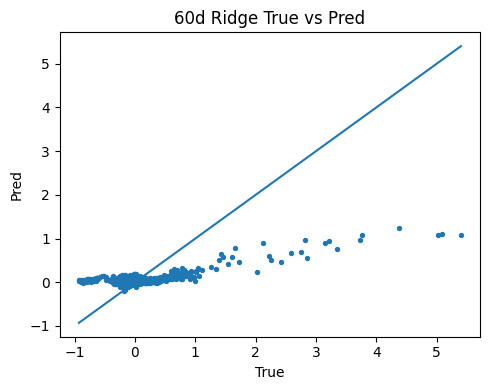

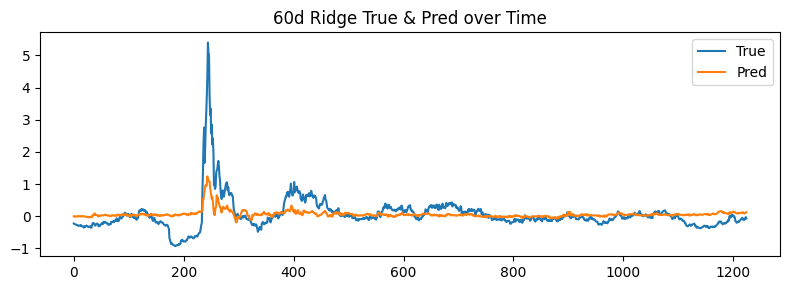

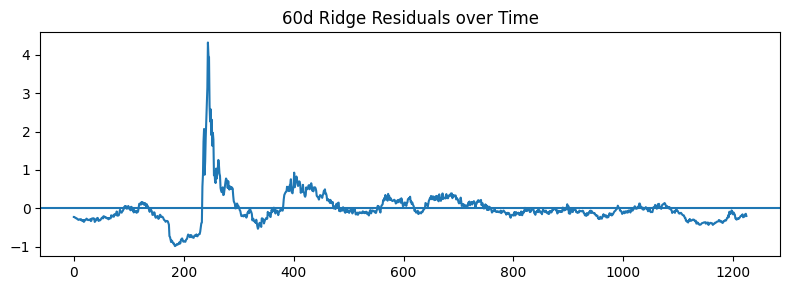

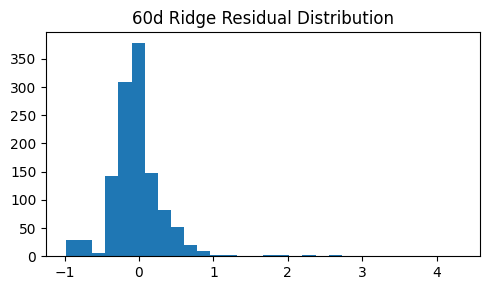

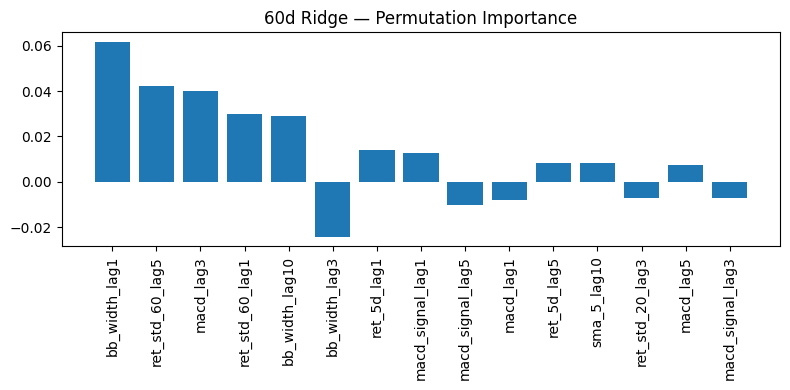


Walk-forward CV (RMSE) for best model:
Splits RMSE: [0.630655 0.142036 0.137854 0.206489 0.57498 ]
Mean RMSE: 0.338402  | Std: 0.217973


In [18]:
print("\n==================== 60-DAY RETURN REGRESSION ====================")
res60, name60, model60 = study_return_regression_horizon(dft, price_col, horizon_days=60, train_frac=TRAIN_FRAC)

# -------- Volatility Regression (your Study 2) --------
def realized_vol(series, win=5):
    return series.pct_change().rolling(win).std()

def study2_volatility_regression(dft, price_col, train_frac=0.8):
    """
    Predict next-day realized vol (here: 5-day rolling std, shifted -1).
    Includes same evaluation & importance diagnostics.
    """
    d = dft.copy()
    d["rv_5"] = realized_vol(d[price_col], win=5)
    d["y_vol_next"] = d["rv_5"].shift(-1)

    # Use same lagged feature space
    feature_cols = [c for c in d.columns if c.endswith("_lag1") or c.endswith("_lag3") or c.endswith("_lag5") or c.endswith("_lag10")]
    data = d.dropna(subset=feature_cols + ["y_vol_next"]).reset_index(drop=True)

    X = data[feature_cols].values
    y = data["y_vol_next"].values

    split_idx = int(len(data) * train_frac)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    models = {
        "LinearRegression": Pipeline([("scaler", StandardScaler()), ("reg", LinearRegression())]),
        "Ridge": Pipeline([("scaler", StandardScaler()), ("reg", Ridge())]),
        "Lasso": Pipeline([("scaler", StandardScaler()), ("reg", Lasso())]),
        "RandomForestReg": RandomForestRegressor(n_estimators=600, random_state=RSEED),
        "GradientBoostingReg": GradientBoostingRegressor(random_state=RSEED),
        "ExtraTreesReg": ExtraTreesRegressor(n_estimators=600, random_state=RSEED),
        "KNNReg": Pipeline([("scaler", StandardScaler()), ("reg", KNeighborsRegressor(n_neighbors=15))]),
    }
    if HAS_XGB:
        models["XGBReg"] = XGBRegressor(
            n_estimators=700, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=RSEED
        )

    rows, fitted = [], {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        metrics = print_metrics(y_test, pred, label=f"VolReg {name}")
        rows.append({"Model": name, **metrics})
        fitted[name] = model

    results_df = pd.DataFrame(rows).sort_values(by=["RMSE","MAE"]).reset_index(drop=True)
    print("\n=== Volatility Regression — Results (sorted by RMSE, then MAE) ===")
    display(results_df)

    # Best model by RMSE
    best_name = results_df.iloc[0]["Model"]
    best_model = fitted[best_name]
    print("\nBest Volatility model (by RMSE):", best_name)

    # Diagnostics for best model
    y_pred_best = best_model.predict(X_test)
    residual_diagnostics(y_test, y_pred_best, title_prefix=f"VolReg {best_name}")

    # Built-in + permutation importance
    feature_names = np.array(feature_cols)
    built_in_importance(best_model, feature_names, title=f"VolReg {best_name} — Built-in Feature Importance")
    permutation_importance_plot(best_model, X_test, y_test, feature_names,
                                scoring="neg_mean_squared_error",
                                title=f"VolReg {best_name} — Permutation Importance")

    # Walk-forward CV
    print("\nWalk-forward CV (RMSE) for best volatility model:")
    rmses = walkforward_cv_rmse(best_model, X, y, splits=5)
    print("Splits RMSE:", np.round(rmses, 6))
    print("Mean RMSE:", np.round(rmses.mean(), 6), " | Std:", np.round(rmses.std(), 6))

    return results_df, best_name, best_model




==================== VOLATILITY REGRESSION (Next-day) ====================

[VolReg LinearRegression] RMSE=0.018052 | MAE=0.010770 | R2=0.6162 | MAPE=0.4202

[VolReg Ridge] RMSE=0.018037 | MAE=0.010773 | R2=0.6168 | MAPE=0.4205

[VolReg Lasso] RMSE=0.032147 | MAE=0.016407 | R2=-0.2171 | MAPE=0.4454

[VolReg RandomForestReg] RMSE=0.023611 | MAE=0.011531 | R2=0.3435 | MAPE=0.4246

[VolReg GradientBoostingReg] RMSE=0.022092 | MAE=0.010652 | R2=0.4252 | MAPE=0.3652

[VolReg ExtraTreesReg] RMSE=0.023948 | MAE=0.011529 | R2=0.3246 | MAPE=0.4306

[VolReg KNNReg] RMSE=0.025619 | MAE=0.013507 | R2=0.2270 | MAPE=0.4338

[VolReg XGBReg] RMSE=0.024788 | MAE=0.012071 | R2=0.2764 | MAPE=0.4283

=== Volatility Regression — Results (sorted by RMSE, then MAE) ===


,Model,RMSE,MAE,R2,MAPE
0,Ridge,0.018037,0.010773,0.616836,0.420463
1,LinearRegression,0.018052,0.010770,0.616216,0.420160
2,GradientBoostingReg,0.022092,0.010652,0.425180,0.365166
3,RandomForestReg,0.023611,0.011531,0.343468,0.424649
4,ExtraTreesReg,0.023948,0.011529,0.324577,0.430559
5,XGBReg,0.024788,0.012071,0.276364,0.428313
6,KNNReg,0.025619,0.013507,0.227019,0.433850
7,Lasso,0.032147,0.016407,-0.217128,0.445420



Best Volatility model (by RMSE): Ridge


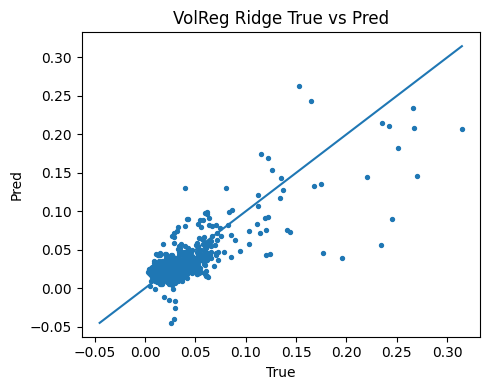

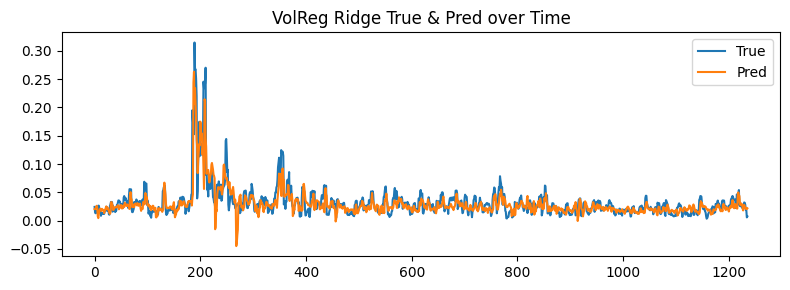

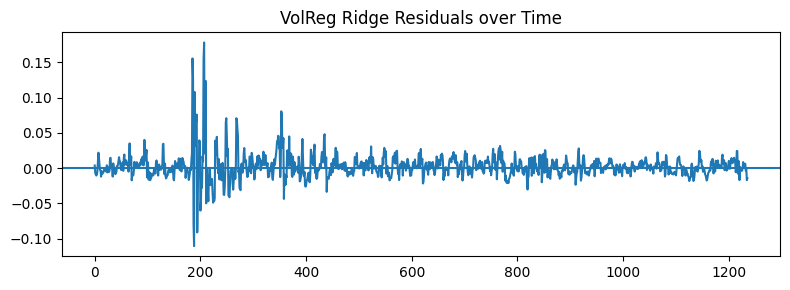

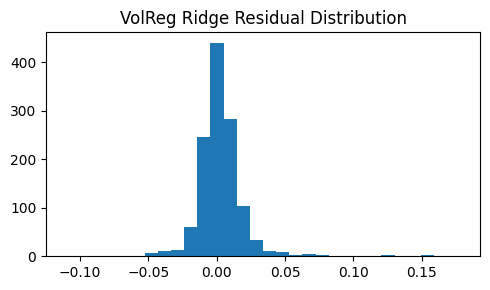

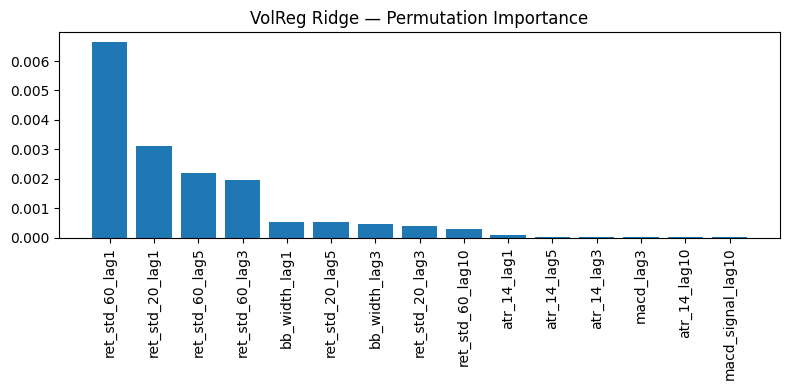


Walk-forward CV (RMSE) for best volatility model:
Splits RMSE: [0.009226 0.009018 0.006102 0.012579 0.017004]
Mean RMSE: 0.010786  | Std: 0.003725


In [19]:
print("\n==================== VOLATILITY REGRESSION (Next-day) ====================")
res_vol, name_vol, model_vol = study2_volatility_regression(dft, price_col, train_frac=TRAIN_FRAC)